In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
IMG_SIZE = 299
class_map = {'OK':0, 'NG':1}

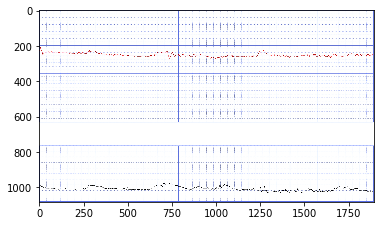

In [4]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
data_path = '/content/gdrive/My Drive/ECG/*/*.jpg'
img_paths = glob(data_path)
img = cv2.imread(img_paths[0])
plt.imshow(img)

((1083, 1895, 3), (299, 299, 3))

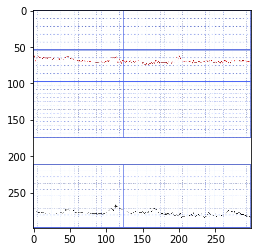

In [5]:
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [6]:
img_path = img_paths[0]
img_path

'/content/gdrive/My Drive/ECG/NG/full_58482082-0.jpg'

In [7]:
cls = img_path.split('/')[-2]
cls

'NG'

In [8]:
class_map[cls]

1

In [0]:
import numpy as np
data_count = len(img_paths)
x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3))
y = np.zeros((data_count, ))

In [10]:
from tqdm.auto import tqdm
for i, path in tqdm(enumerate(img_paths)):
  img = cv2.imread(path)
  img_resize = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  cls = path.split('/')[-2]

  x[i] = img_resize
  y[i] = class_map[cls]

In [11]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0.0: 87, 1.0: 27}

In [12]:
from keras.utils import to_categorical
import keras
from keras.applications.inception_resnet_v2 import preprocess_input
from sklearn.model_selection import train_test_split
x = preprocess_input(x)
y_onehot = to_categorical(y, num_classes=2)


Using TensorFlow backend.


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y_onehot, test_size=0.1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((102, 299, 299, 3), (12, 299, 299, 3), (102, 2), (12, 2))

In [14]:
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten
from keras.models import Model
base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(base_model.input, predictions)














219062272/219055592 [==============================] - 5s 0us/step


In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [16]:
model.compile(loss="categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy"])

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint = ModelCheckpoint('drive/My Drive/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

In [18]:
logs = model.fit(x_train, y_train,
                batch_size=32,
                epochs=100,
                verbose=1,
                callbacks=[early_stopping, reduce_lr],     
                validation_data=(x_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 102 samples, validate on 12 samples
Epoch 1/100
102/102 [==============================] - 60s 592ms/step - loss: 0.6826 - acc: 0.7157 - val_loss: 1.6242 - val_acc: 0.5833
Epoch 2/100
102/102 [==============================] - 3s 25ms/step - loss: 0.4441 - acc: 0.8137 - val_loss: 0.4574 - val_acc: 0.8333
Epoch 3/100
102/102 [==============================] - 2s 24ms/step - loss: 0.1739 - acc: 0.9412 - val_loss: 4.0364 - val_acc: 0.5000
Epoch 4/100
102/102 [==============================] - 2s 24ms/step - loss: 0.1735 - acc: 0.9118 - val_loss: 0.6223 - val_acc: 0.8333
Epoch 5/100
102/102 [==============================] - 2s 24ms/step - loss: 0.1601 - acc: 0.9314 - val_loss: 0.8904 - val_acc: 0.8333

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/100
102/102 [==============================] - 2s 24ms/step - loss: 0.1714 - acc: 0.9412 - val_lo

In [0]:
history = logs.history

Text(0.5, 1.0, 'acc')

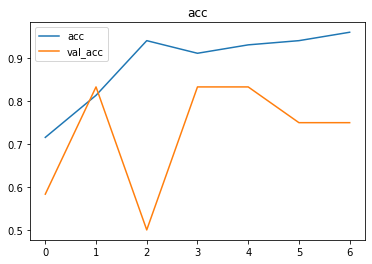

In [20]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

Text(0.5, 1.0, 'loss')

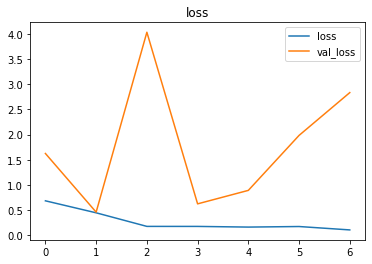

In [21]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(x_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = [str(i) for i in range(2)]
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))

(12,) (12,)
              precision    recall  f1-score   support

           0       0.70      1.00      0.82         7
           1       1.00      0.40      0.57         5

    accuracy                           0.75        12
   macro avg       0.85      0.70      0.70        12
weighted avg       0.82      0.75      0.72        12

[[7 0]
 [3 2]]


In [23]:
model.evaluate(x_train, y_train)

102/102 [==============================] - 1s 8ms/step


[0.6253469072136261, 0.9313725490196079]

In [24]:
model.evaluate(x_test, y_test)

12/12 [==============================] - 0s 10ms/step


[2.835437774658203, 0.75]